In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

from functools import partial
import itertools as it

import pandas as pd
import numpy as np
import datetime as dt
import os, sys

from pathlib import Path

import torch
import ray
from ray import train, tune

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm

from src.datasets import daocensus

%load_ext autoreload
%autoreload 2

### Parameters

In [2]:
TRANSFORMER_MODEL = "all-mpnet-base-v2"
ORG_NAME = 'Decentraland'

# Evaluation
N_SPLITS: int = 10
SKIP_SPLIT: int = 0
K_RECOMMENDATIONS: List[int] = [5, 10]

# k for K Nearest Neighbors
# KNN_K: int = 1

In [3]:
dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
dfv['voter'] = dfv['voter'].astype('str')
dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')
print(dfv.info())
print(dfp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  object        
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(7)
memory usage: 8.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942 entries, 0 to 1941
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------ 

## Getting the embeddings of each proposal

In [4]:
from sentence_transformers import SentenceTransformer
import pickle

In [5]:
model = SentenceTransformer(TRANSFORMER_MODEL)

In [6]:
embeddings_folder = Path('./data/daos-census-text')
embeddings_file = embeddings_folder / 'embeddings.pkl'

dfp['title-description'] = dfp['title'] + '\n' + dfp['description']

if not embeddings_folder.exists():
    embeddings_folder.mkdir()

embeddings = None
if embeddings_file.exists():
    print('Embeddings file saved, reading it instead...')
    with open(embeddings_file, 'rb') as f:
        obj = pickle.load(f)
    
    embeddings = obj['embeddings']
    print("Embeddings shape:", embeddings.shape)
    ids = obj['ids']

if embeddings is None:
    embeddings = model.encode(dfp['title-description'], show_progress_bar=True, normalize_embeddings=True)
    with open(embeddings_file, 'wb+') as f:
        pickle.dump({'sentences': dfp['title-description'], 'embeddings': embeddings, 'ids': dfp['id']}, f, protocol=pickle.HIGHEST_PROTOCOL)
    ids = dfp['id']

Embeddings file saved, reading it instead...
Embeddings shape: (1942, 768)


In [7]:
embeddings_sum = embeddings.sum(axis=0)
print(embeddings_sum.shape)
embeddings = embeddings / embeddings_sum
embeddings

(768,)


array([[ 1.1403942e-03,  8.6159667e-04,  6.9543906e-04, ...,
        -2.7190472e-03, -1.0145850e-03,  3.9847512e-03],
       [-4.0623921e-04,  4.4145260e-04,  9.4736629e-04, ...,
         1.6015386e-03,  1.8749244e-03, -2.8607671e-04],
       [ 2.3584028e-03,  5.8685098e-04,  7.1522983e-04, ...,
        -2.2754685e-03, -1.4056198e-04, -3.7364415e-03],
       ...,
       [ 7.4751978e-04,  6.6007749e-04,  6.3091848e-04, ...,
         2.4024327e-03, -2.0156235e-03,  3.5178075e-03],
       [ 1.0567971e-03,  4.8019559e-05,  3.8508393e-04, ...,
        -2.2719151e-04,  3.0133147e-03, -4.8025078e-03],
       [-7.7102036e-04,  5.3977495e-04,  6.2477670e-04, ...,
         4.1932142e-03, -3.2050564e-05,  5.8417697e-03]], dtype=float32)

In [8]:
dfp['embeddings'] = list(embeddings)

## Getting the embeddings of each user

The embeddings of each user are the embeddings of each proposal the user has voted in

In [9]:
dfp['nbidx'] = dfp.index
_dfv = dfv.merge(dfp[['id', 'nbidx']], how='left', left_on='proposal', right_on='id')
print('dfp:', dfp.shape, 'dfv:', dfv.shape, '_dfv:', _dfv.shape)
votes_embeddings = embeddings[_dfv['nbidx']]
votes_embeddings.shape

dfp: (1942, 17) dfv: (116560, 10) _dfv: (116560, 12)


(116560, 768)

In [10]:
x=np.array([3,4])
x = x / np.linalg.norm(x)
print(x)
print(np.linalg.norm(x))
print(x.sum())

[0.6 0.8]
1.0
1.4


In [11]:
voter_embeddings = dfv.groupby('voter').apply(lambda x: votes_embeddings[x.index].sum(axis=0))
voter_embeddings = voter_embeddings.apply(lambda x: x/np.linalg.norm(x))
# msk = (np.linalg.norm(np.stack(voter_embeddings.to_numpy()), axis=1) > 0.9)
voter_embeddings

voter
0x0019220ddabe5b8438a6be6ebca31ef01ca69965    [0.0005797436, 0.0008813106, 0.0009436921, 0.0...
0x0023a0bf1cb20362f847dfc977d2c815f6ac8021    [0.0058569475, 0.0020814762, 0.0020506687, 0.0...
0x0026dd985da16f70e9d9cf739b08c6cdf6a7f407    [0.00049382605, 0.000369442, 0.0001715262, 0.0...
0x0029ab135b5be72168bf80f140d60a9264dbd0c5    [0.0015583907, 0.0006184035, 0.0007542482, 0.0...
0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34    [0.0029788632, 0.0022017027, 0.0020975238, 0.0...
                                                                    ...                        
0xffd92144cafd599a5a93e4805ca4d8f0e666d623    [0.0018572637, 0.0015811239, 0.0013924055, 0.0...
0xffd9cd75445459184a4b89a0fbd1720ab2957738    [0.001981472, 0.0022674527, 0.0011901953, 0.00...
0xffe6d9d29480d0673c4fc46da22d21e245c8e731    [0.0024959077, 0.0013624564, 0.0004591559, 0.0...
0xffed2f64c9f796d4258618a7a375ed816205821a    [-0.00015786002, 0.0002711929, 0.0002997918, 8...
0xfff28923092a8294456206a6d0734514

In [12]:
dfv.groupby('voter').size().sort_values()

voter
0x7dc3331bc545a41e566dfbbb3d8851bf4762486f      1
0x7ae0a65d329bc202e83a360d9afc880063c12337      1
0x7b07608c3e4ef235c7a5e15f02a7fa9552ce113f      1
0x7b29be2f106712287024e6228e015d44cdfa0dec      1
0x7b2ec1a291a0a4dd08d65ab34a62bda1cca618c6      1
                                             ... 
0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8    652
0xd6eff8f07caf3443a1178407d3de4129149d6ef6    727
0xb44ac514588be99870220d12120815bc3d349507    729
0x521b0fef9cdcf250abaf8e7bc798cbe13fa98692    760
0xc54a6c3778016b06cbd126ccc3b5bc06c5f666fb    885
Length: 7268, dtype: int64

## Making recommendations with cosine similarity

Because they are normalized, our ranking score can be just the dot product of a user and a proposal

In [13]:
user_emb = voter_embeddings['0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8']
scores = embeddings @ user_emb
scores.argsort()

array([ 324,  940,  320, ...,  413, 1134,  457])

In [14]:
list(range(10))[-3:]

[7, 8, 9]

In [15]:
def recommend_emb(emb, k, t = None):
    """
    Args:
        emb: The embedding of the item/user to recommend items to
        k (int): The number of items to recommend
        t (timestamp): Simulate that the recommendation is made at time `t`
            i.e: Filter out already closed proposals or not yet open
    """
    # 1D n_proposals
    scores = embeddings @ emb

    if t:
        msk = (dfp['start'] < t) & (t < dfp['end'])
        scores[msk] = -np.inf
    
    best = (-scores).argsort()

    dfbest = dfp.iloc[best[:k]].copy()
    dfbest['score'] = scores[best[:k]]
    return dfbest

In [16]:
def recommend_user(voter: str, k: int = 5, t: Optional[np.datetime64] = None):
    # 1D emb_size
    user_emb = voter_embeddings[voter]
    return recommend_emb(user_emb, k, t)

recommend_user('0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8')[['title', 'description', 'score']]

,title,description,score
457,Logarithmic VP conversion after a certain amou...,> by 0x5985eb4a8e0e1f7bca9cc0d7ae81c2943fb205b...,6.910858
1134,Should Voter Power Delegation be activated in ...,> by 0x9982b469910c2ee2ea566dcfcc250cdd3405639...,5.948124
413,Can we implement 'R' and 'G' keys to allow for...,> by 0xb2223f4038def8a62a86e3c4b108cdfe00a74c4...,5.480871
873,Should VP keep assigned to the landowner in a ...,> by 0x87956abc4078a0cc3b89b419928b857b8af826e...,5.170687
1736,Create Group Chats between Mutual Friends,> by 0x988262eb3225ea4690f6b4846e36c700345bf6f...,4.964846


In [17]:
def recommend_proposal(proposal: str, k: int = 5, t: Optional[np.datetime64] = None):
    # 1D emb_size
    prop_emb = dfp.set_index('id')['embeddings'][proposal]
    return recommend_emb(prop_emb, k, t)

display(dfp.set_index('id').loc['433b7e43-77b0-5ea1-bac3-0c3071363a56'])
recommend_proposal('433b7e43-77b0-5ea1-bac3-0c3071363a56')

platform                                                        snapshot
name                                                        Decentraland
platform_deployment                                     snapshot.dcl.eth
deployment                          41fd8de5-f8e2-5023-86a3-825c49e9ad7f
platform_proposal      0xdbe9b2df1d00c0d264bffb3f10f1332a82d8a8a70c12...
author                        0xbb7b59afa3a0e5be143b8fe9c641f00c1ecb9d69
date                                                 2023-02-14 16:19:06
votes_count                                                          385
proposal_id            0xdbe9b2df1d00c0d264bffb3f10f1332a82d8a8a70c12...
title                  Should DAO proposals have a pre-defined 'Absta...
description            > by 0x511a22cdd2c4ee8357bb02df2578037ffe8a4d8...
start                                                2023-02-14 16:19:00
end                                                  2023-02-28 16:19:00
title-description      Should DAO proposals have a 

,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,votes_count,proposal_id,title,description,start,end,title-description,embeddings,nbidx,score
940,snapshot,Decentraland,snapshot.dcl.eth,5f8989a6-464f-57ef-bbee-74f3ce8b001f,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmcY88YFJLgiMatBPD1j9KUxBwPhymW5DdVP4JQDj53jYr,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-12-23 22:13:33,14,QmcY88YFJLgiMatBPD1j9KUxBwPhymW5DdVP4JQDj53jYr,Petition to add event reviews so we can improv...,> by 0xbef69e080a0b127f7cf6f3b658f07c90588cea6...,2021-12-23 22:13:00,2021-12-30 22:13:00,Petition to add event reviews so we can improv...,"[-0.0015171164, 0.0007642187, 0.00042039528, 0...",940,2.342395
1537,snapshot,Decentraland,snapshot.dcl.eth,613dbb55-2dd7-51fc-a289-c1a39a6461ff,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,0xfad0ce3f336f9104fd8d5cc2cb3c012c21a2116d7f7b...,0xbb7b59afa3a0e5be143b8fe9c641f00c1ecb9d69,2023-03-06 20:56:57,96,0xfad0ce3f336f9104fd8d5cc2cb3c012c21a2116d7f7b...,Community support for a paid pre-check on link...,> by 0x895be97bdb9f8a244c472b18ea96dee39ddf8fe...,2023-03-06 20:56:00,2023-03-11 20:56:00,Community support for a paid pre-check on link...,"[-0.00037167242, 0.00045459915, 8.636677e-05, ...",1537,2.168351
1644,snapshot,Decentraland,snapshot.dcl.eth,a7eabea1-95b5-5621-8bc5-8f09f313c45e,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,bafkreidmcnjlewiwuvyty5k2atld2qtnesk5dky2gwhwo...,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2022-09-07 15:39:27,92,bafkreidmcnjlewiwuvyty5k2atld2qtnesk5dky2gwhwo...,Should there be limited time to change voting ...,> by 0x247e0896706bb09245549e476257a0a1129db41...,2022-09-07 15:39:00,2022-09-12 15:39:00,Should there be limited time to change voting ...,"[0.00034874497, 0.00051068235, 0.00022908037, ...",1644,2.036432
1242,snapshot,Decentraland,snapshot.dcl.eth,5be72d6c-2388-5aaa-8ac6-20be847a82cc,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,0xdce2b640a47ba0c44bfa9e9a88ad8bffb9a5a3ffbff5...,0xbb7b59afa3a0e5be143b8fe9c641f00c1ecb9d69,2023-01-06 17:54:38,201,0xdce2b640a47ba0c44bfa9e9a88ad8bffb9a5a3ffbff5...,Should DAO proposals have a pre-defined 'Absta...,> by 0x511a22cdd2c4ee8357bb02df2578037ffe8a4d8...,2023-01-06 17:54:00,2023-01-11 17:54:00,Should DAO proposals have a pre-defined 'Absta...,"[-0.0007028324, 0.0001626759, -7.843193e-06, -...",1242,2.001611
1149,snapshot,Decentraland,snapshot.dcl.eth,62662ecc-3126-5798-bbd9-b1421082be58,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmVCfrGX892iaDLkp5dBNJRa93U2DVbg3JNcD14mfGvMS1,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2022-05-19 23:18:01,161,QmVCfrGX892iaDLkp5dBNJRa93U2DVbg3JNcD14mfGvMS1,MANA incentives for USDC-ICE LP on QuickSwap,> by 0x521b0fef9cdcf250abaf8e7bc798cbe13fa9869...,2022-05-19 23:18:00,2022-05-24 23:18:00,MANA incentives for USDC-ICE LP on QuickSwap\n...,"[0.0009039452, 0.00047539602, 0.0006336307, 0....",1149,1.982089


### Evaluation

First, we will evaluate if the user recommendations are any good using common off-line metrics.

In [18]:
def recommendNLPNaive(train: pd.DataFrame, users, proposals, k: int = 5, remove_training: bool = True, min_score: float = 0):  
    # Create voter embeddings (filtering that they are in train)
    # TODO: Add some kind of discount rate over time
    voter_embeddings = dfv[dfv['voter'].isin(users) & dfv['proposal'].isin(train['itemID'])].groupby('voter').apply(lambda x: votes_embeddings[x.index].sum(axis=0))
    voter_embeddings = voter_embeddings.apply(lambda x: x/np.linalg.norm(x))
    np_voter_embeddings = np.stack(voter_embeddings.to_numpy())
    
    # Remove score from proposals not in `proposals`
    msk = ids.isin(proposals)
    tr_embeddings = embeddings.copy()
    tr_embeddings[~msk] = 0
    
    scores = np_voter_embeddings @ tr_embeddings.T
    
    # Remove score from proposals already voted by user
    if remove_training:
        trainu = train[train['userID'].isin(users)]
        itemID2idx = dfp.set_index('id')['nbidx']
        voterID2idx = pd.Series(data=np.arange(len(voter_embeddings)), index=voter_embeddings.index)
        scores[voterID2idx[trainu['userID']], itemID2idx[trainu['itemID']]] = -np.inf
        
    best = (-scores).argsort(axis=1)
    topk = best[:, :k]
    
    # create df with columns
    # userID, itemID, prediction
    uid = np.repeat(np.arange(np_voter_embeddings.shape[0]), k)
    iid = topk.flatten()
    
    # transform int to id
    df = pd.DataFrame({
        'userID': voter_embeddings.index[uid],
        'itemID': ids[iid].astype(str),
        # 'prediction': 1,
        'prediction': scores[uid, iid],
    })
    return df[df['prediction'] > min_score].reset_index(drop=True)

# train = train_filtered
# users = test_filtered['userID'].unique()
# proposals = test_filtered['itemID'].unique()
# k = 3
# remove_training = True

In [19]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from src.datasets import to_microsoft
from src.model_selection import timeIntervalSplit

In [20]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [21]:
df = to_microsoft(dfv)

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 
metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals)]
    test_filtered = test[test['itemID'].isin(open_proposals)]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    for k_recs in K_RECOMMENDATIONS:
        # print('Tested score:')
        # recs = recommendNLPNaive(train_filtered, test_filtered['userID'].unique(), test_filtered['itemID'].unique(), k_recs)
        recs = recommendNLPNaive(train, test_filtered['userID'].unique(), open_proposals, k_recs)
        if check_train_recs(recs, train, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            msk = recs.set_index(['userID', 'itemID']).index.isin(
                train.set_index(['userID', 'itemID']).index
            )
            display(recs[msk])
            assert False
            
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{K_RECOMMENDATIONS}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
        
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{K_RECOMMENDATIONS}:'.ljust(15), f'{r:.3}')
    
    # print()

  0%|          | 0/10 [00:00<?, ?it/s]

,precision@5,ndcg@5,map@5,precision@10,ndcg@10,map@10,baseline precision@5,baseline precision@10,baseline ndcg
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.196551,0.453894,0.365783,0.129290,0.494681,0.393672,0.145534,0.136072,0.294985
std,0.047164,0.179615,0.205003,0.031291,0.156334,0.191869,0.074635,0.045895,0.202287
min,0.128358,0.268518,0.174850,0.086735,0.349442,0.211890,0.013223,0.057447,0.034569
25%,0.171236,0.334066,0.230428,0.105191,0.399619,0.278464,0.092749,0.105087,0.175023
50%,0.195455,0.442521,0.327914,0.120075,0.453993,0.343601,0.153866,0.148637,0.274016
75%,0.236730,0.460248,0.349633,0.159877,0.501424,0.389047,0.194445,0.172823,0.341228
max,0.262069,0.882361,0.864773,0.173737,0.890028,0.869113,0.268333,0.190909,0.747259


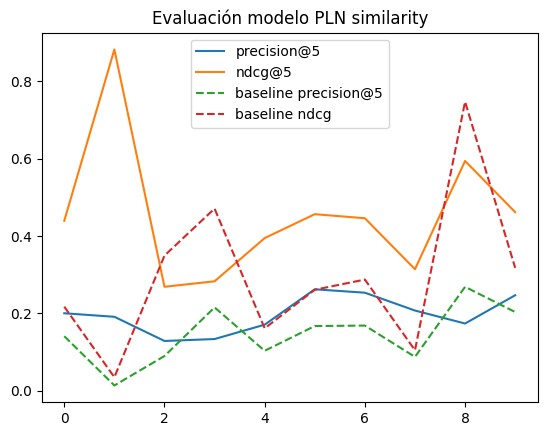

In [22]:
mdf = pd.DataFrame(metrics)
bdf = pd.read_csv(f'./data/baseline/mp-{ORG_NAME}-{N_SPLITS}.csv')

mdf['baseline precision@5'] = bdf['precision@5']
mdf['baseline precision@10'] = bdf['precision@10']
mdf['baseline ndcg'] = bdf['ndcg@5']
fig, ax = plt.subplots()
mdf[['precision@5', 'ndcg@5']].plot(title='Evaluación modelo PLN similarity', ax=ax)
mdf[['baseline precision@5', 'baseline ndcg']].plot(style='--', ax=ax)
mdf.describe()

# Second iteration: PLN with kNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

itemID2idx = dfp.set_index('id')['nbidx']

In [24]:
def filter_proposals_in_train(train, user, proposals):
    msk = train['userID'] == user
    proposals_aready_voted_by_user = train[msk]['itemID'].unique()
    return np.setdiff1d(proposals, proposals_aready_voted_by_user)

In [25]:
def recommendUserKNN(train: pd.DataFrame, user, proposals, top_k: Optional[int] = None, knn_k = 3, do_sampling: Optional[bool] = None, remove_train: bool = True):
    """
    Given the train data (proposals that might be voted or not by the user), recommend k proposals from proposals to the user
    The train data is a DataFrame in microsoft's format
    
    do_sampling (bool) : default None
        if True, makes sampling so the number of positive and negative samples is the same
        if False, doesn't do it
        if None (default), does it when k > 1, but doesn't do it with Nearest Neighbor
    """
    # train['hasVoted'] = train['userID'] == user
    hasVoted = train['userID'] == user

    # Remove recommendations already in training
    # (aka remove from proposals array)
    if remove_train:
        proposals = filter_proposals_in_train(train, user, proposals)

    assert any(hasVoted), 'The user has not voted in any proposal'

    if do_sampling or (do_sampling is None and knn_k > 1):
        # num_samples = train['hasVoted'].value_counts().min() # [True]
        num_samples = hasVoted.value_counts().min() # [True]
        train = train.groupby(hasVoted).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)
        hasVoted = train['userID'] == user
    
    known_embeds = embeddings[itemID2idx[train['itemID']]]

    knn = KNeighborsClassifier(knn_k) # , metric='cosine')
    knn.fit(known_embeds, hasVoted)# train['hasVoted'])

    predict_embeds = embeddings[itemID2idx[proposals]]
    aux = knn.predict_proba(predict_embeds)
    p = knn.predict_proba(predict_embeds)[:, 1] # Probabilidad de que sea True

    if top_k:
        best = (1-p).argsort()[:top_k]
        p = p[best]
        proposals = proposals[best]
    
    return pd.DataFrame({
        'userID': user,
        'itemID': proposals,
        'prediction': 1,
        'score': p,
    })

u = '0xe44782afe398800d7190796018c4b865e32ff806'
proposals_voted_by_user = test_filtered[test_filtered['userID'] == u]
print(f'The user {u} voted in {len(proposals_voted_by_user)} proposals')
# p = recommendUserKNN(train, u, test_filtered['itemID'].unique().copy(), 5, do_sampling=True)
# p['correct'] = p['itemID'].isin(proposals_voted_by_user['itemID'])
# p

The user 0xe44782afe398800d7190796018c4b865e32ff806 voted in 0 proposals


In [26]:
from recommenders.datasets.pandas_df_utils import filter_by

def recommendMostVoted(train: pd.DataFrame, user, proposals, top_k: Optional[int] = None, remove_train=True):
    bestVotes = train[train['itemID'].isin(proposals)]['itemID'].value_counts()
    df = pd.DataFrame({
        'userID': user,
        'itemID': bestVotes.index,
        'prediction': 1,
        'score': bestVotes,
    })
    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
    return df.head(top_k).reset_index(drop=True)

u = '0xe44782afe398800d7190796018c4b865e32ff806'
proposals_voted_by_user = test_filtered[test_filtered['userID'] == u]
print(f'The user {u} voted in {len(proposals_voted_by_user)} proposals')
recommendMostVoted(train_filtered.copy(), u, test_filtered['itemID'].unique(), 5)

The user 0xe44782afe398800d7190796018c4b865e32ff806 voted in 0 proposals


,userID,itemID,prediction,score


In [27]:
import multiprocessing as mp
from multiprocessing import Pool

def recommendUserKNNwithFallback(train, user, proposals, top_k = None, knn_k: int = 1, remove_train: bool = True, do_sampling = None):
    """ If the user has not voted in any proposal in `train`, we fall back to recommending
    the most voted proposal in `proposals`
    """
    if remove_train:
        proposals = filter_proposals_in_train(train, user, proposals)
    if (user == train['userID']).sum() >= knn_k:
        df = recommendUserKNN(train, user, proposals, top_k, knn_k, remove_train=False, do_sampling=do_sampling)
        df['scoreType'] = 'knn'
        return df
    else:
        df = recommendMostVoted(train, user, proposals, top_k, remove_train=False)
        df['scoreType'] = 'mv'
        return df

def recommendNLPKNN(train: pd.DataFrame, users, proposals, top_k: int = 5, knn_k: int = 1, do_sampling=None, cpus=-1):
    # Create voter embeddings
    assert knn_k >= 1
    
    with Pool(mp.cpu_count()//4 if cpus==-1 else cpus) as pool:
        return pd.concat(
            tqdm(
                pool.imap(
                    partial(
                        recommendUserKNNwithFallback, 
                        train, 
                        proposals=proposals, 
                        top_k=top_k,
                        knn_k=knn_k,
                        do_sampling=do_sampling),
                    users),
                total=len(users),
                leave=False,
            )
        )

recommendNLPKNN(train, test_filtered['userID'].unique(), test_filtered['itemID'].unique(), top_k=1)

  0%|          | 0/134 [00:00<?, ?it/s]

,userID,itemID,prediction,score,scoreType
0,0x0dd1338a416af72655aacfbccf082762973cceff,1902b64e-6240-5623-947c-8c6676fdafcd,1,0.0,knn
0,0x4262f8bb5bd9ad132782d2a7279b532a1dc6bcbf,1902b64e-6240-5623-947c-8c6676fdafcd,1,0.0,knn
0,0x854aeb9840b9f1062745822bfbd77daea53f83cf,7c34f3bf-850d-5ebc-af02-0ea664ac1837,1,0.0,knn
0,0x076b91acf9316eae15beae5daa054df8ee61959e,5ac1a277-352f-5e61-bac8-0669c816740c,1,0.0,knn
0,0xaae9d8bff1ef3606c51545b953e0137abb7ce7f3,1902b64e-6240-5623-947c-8c6676fdafcd,1,0.0,knn
...,...,...,...,...,...
0,0x303cd760680d2a6b474665e8cf7e99f32d6337dc,1902b64e-6240-5623-947c-8c6676fdafcd,1,0.0,knn
0,0xedf458ce355c755e1973778b51b917066d4c0bad,1902b64e-6240-5623-947c-8c6676fdafcd,1,0.0,knn
0,0x0d6a9963f7b362c3d50cfdfdc9207b4d8e766c13,1902b64e-6240-5623-947c-8c6676fdafcd,1,0.0,knn
0,0x2182744a243e50dc5bf8e1cb4657748e19646f60,1902b64e-6240-5623-947c-8c6676fdafcd,1,0.0,knn


In [28]:
print(mp.cpu_count())

24


### Evaluation

Usaremos el método del codo para ver cual de todos es mejor

In [29]:
df = to_microsoft(dfv)

def knn_usage_at_k(test, recs, k):
    return (recs['scoreType'] == 'knn').mean()

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = {'precision': precision_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'knnUsage': knn_usage_at_k, } # 'recall': recall_at_k, 
metrics = { 'k':[], } | {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
for k in tqdm(range(1,10)):
    for i, (train, test) in enumerate(tqdm(folds)):
        t = train.timestamp.max()
        # print(f"===== Training on fold {i} (t: {t})  =====")
        # print(f"Ratings train: {len(train)}, test: {len(test)}")
    
        open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
        # print(f"Currently open proposals: {len(open_proposals)}")
    
        train_filtered = train[train['itemID'].isin(open_proposals) ].copy()
        test_filtered = test[test['itemID'].isin(open_proposals) ]
        # print(f"Train votes in open proposals: {len(train_filtered):3}")
        # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

        train = train.copy()
        for k_recs in K_RECOMMENDATIONS:
            recs = recommendNLPKNN(train, test_filtered['userID'].unique(), open_proposals, k_recs, k)
            if check_train_recs(recs, train, ['userID', 'itemID']):
                print("Warning: There are recommendations that were true in training", file=sys.stderr)
                # print(recs.score.describe())
                # assert False
        
            # print('Tested score:')
            for m, f in metrics_f.items():
                r = f(test_filtered, recs, k=k_recs)
                metrics[m+f'@{k_recs}'].append(r)
    
        metrics['k'].append(k)
        # print()

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
mdf = pd.DataFrame(metrics)
ax = sns.lineplot(mdf.groupby('k').mean())
bdf = pd.read_csv(f'./data/baseline-mp-{ORG_NAME}-{N_SPLITS}.csv')
plt.ylim(0)
plt.xlim((1, mdf['k'].max()))
ax.axhline(bdf['precision@5'].mean(), color='red', linestyle='dashed')
ax.axhline(bdf['ndcg@5'].mean(), color='yellow', linestyle='dashed')

In [ ]:
mdf = pd.DataFrame(metrics)
fig = px.line(mdf.groupby('k').mean())
fig.add_hline(y=bdf['precision@5'].mean(), line_dash='dash', line_color='green')
fig.add_hline(y=bdf['ndcg@5'].mean(), line_dash='dash', line_color='green')
fig.update_yaxes(range=[0, 1])
fig

In [ ]:
mdf.groupby('k').describe(percentiles=[.5],).T

In [ ]:
mdf = pd.DataFrame(metrics)
mdf = mdf[mdf['k'] == 1]
bdf = pd.read_csv(f'./data/baseline/mp-{ORG_NAME}-{N_SPLITS}.csv')

mdf['baseline precision'] = bdf['precision@5']
mdf['baseline ndcg'] = bdf['ndcg@5']
fig, ax = plt.subplots()
mdf[['precision@5', 'ndcg@5']].plot(title='Evaluación modelo PLN kNN', ax=ax)
mdf[['baseline precision', 'baseline ndcg']].plot(style='--', ax=ax)
mdf.describe()